<a href="https://colab.research.google.com/github/ivyclare/PrivateAI/blob/master/MNIST_PATE_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PATE Analysis on MNIST

http://www.cleverhans.io/privacy/2018/04/29/privacy-and-machine-learning.html
Our PATE approach at providing differential privacy to machine learning is based on a simple intuition: if two different classifiers, trained on two different datasets with no training examples in common, agree on how to classify a new input example, then that decision does not reveal information about any single training example. The decision could have been made with or without any single training example, because both the model trained with that example and the model trained without that example reached the same conclusion.

====================

In order to train MNIST in a differentially private manner, we need 2 main components; private datasets (teachers) and public unlabelled dataset (student). MNIST is divided into train and test data. Hence, we'll have to create the teacher and student datasets ourselves. 

We will follow the steps below, to create a privacy preserving MNIST deep learning model:

- Create the teacher and student datasets
    - The training data is divided into non-overlapping subsets
- 

In [1]:
# install syft package to use Private Aggregation of Teacher Ensembles (PATE)
!pip install syft

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# import our libraries
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
import time, os
import math
from syft.frameworks.torch.dp import pate


### Step 1: Create Teacher and Student Datasets

In [0]:
# Load MNIST dataset

data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5,),(0.5,))
                                     ])
# train_data = datasets.MNIST(root=’data’, train=True, download=True, transform=transform)

trainset = datasets.MNIST(root='data', train=True, transform=data_transforms, download=True)

testset = datasets.MNIST(root='data', train=False, transform=data_transforms, download=True)



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
len(trainset), len(testset)


(60000, 10000)

In [6]:
# TEACHERS
#divide train set between teachers and create dataloaders for valid and trainsets
num_teachers = 10
valid_per = 0.3 #20% for validation
batch_size = 64


def teacher_dataloaders(transet=trainset, num_teachers=num_teachers, batch_size=batch_size, valid_per = 0.3):
  trainloaders = []
  validloaders = []
  teacher_data_len = len(trainset) // num_teachers

  for i in range(num_teachers):
    # get particular subset of data
    indice = list(range(i*teacher_data_len, (i+1)*teacher_data_len))
    data_subset = Subset(trainset, indice)
    # split into train and validation set
    valid_size = int(len(data_subset) * valid_per)
    train_size = len(data_subset) - valid_size
    train_subset, valid_subset = torch.utils.data.random_split(data_subset, [train_size,valid_size])
    # print(len(train_subset))
    # print(len(valid_subset))

    #create data loaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

    #add dataloaders to list
    trainloaders.append(trainloader)
    validloaders.append(validloader)
  
  return trainloaders, validloaders

trainloaders, validloaders = teacher_dataloaders()
len(trainloaders), len(validloaders)

(10, 10)

In [10]:
#  # STUDENT 
# split into train and validation set
valid_size = int(len(testset) * 0.3)
train_size = len(testset) - valid_size
student_train_subset, student_valid_subset = torch.utils.data.random_split(testset, [train_size,valid_size])
# print(len(train_subset))
# print(len(valid_subset))

#create data loaders
student_train_loader = DataLoader(student_train_subset, batch_size=batch_size, shuffle=False, num_workers=1)
student_valid_loader = DataLoader(student_valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(student_train_loader), len(student_valid_loader)

(110, 47)

In [0]:

# split = 0.7
# split_ind = int(len(testset) * split)
  
# # validset and testset
# # validset is smaller because dataset of each teacher is small
# private_ind = list(range(0, split_ind))
# public_ind = list(range(split_ind, len(testset)))
# private_set = Subset(testset, private_ind)
# public_set = Subset(testset, public_ind)

# # validloader and testloader
# student_trainloader = torch.utils.data.DataLoader(private_set, batch_size=batch_size, shuffle=True)
# student_validloader = torch.utils.data.DataLoader(public_set, batch_size=batch_size, shuffle=False)

# len(student_trainloader), len(student_validloader)

## Step 2: Train Teachers

In [0]:
# define model
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)
    self.dropout = nn.Dropout(p=0.4)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = F.log_softmax(self.fc4(x), dim=1)

    return x

In [0]:
# training loop
def train(trainloader, validloader, model, optimizer, criterion, epochs, device):
  start = time.time()
  trainloader = trainloaders[0]
  validloader = validloaders[0]
  best_loss = math.inf
  train_results = []
  valid_results = []

  for epoch in range(epochs):   
    model.train()
    running_loss = 0.0
    running_corrects = 0
    valid_corrects = 0
    valid_loss = 0
    
    for images, labels in trainloader:
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()

      outputs = model(images)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      #running_loss += loss.item()
      running_loss += loss.item() * images.size(0)
      running_corrects += torch.sum(preds == labels.data)

      with torch.no_grad():
        model.eval()
        for images, labels in validloader:
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          v_loss = criterion(outputs, labels)

          valid_loss += loss.item() * images.size(0)
          ps = torch.exp(outputs)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          valid_corrects += torch.mean(equals.type(torch.FloatTensor))

      #   # if(valid_loss < best_loss):
      #   #   best_loss = valid_loss
      
        train_loss = running_loss / len(trainloader)
        train_acc = running_corrects.double() / len(trainloader)
        train_results.append([train_loss,train_acc])

        valid_losss = valid_loss / len(validloader)
        valid_acc = valid_corrects / len(validloader)
        valid_results.append([valid_losss,valid_acc])

    print("Epoch: {}/{}".format(epoch, epochs))
    print('\tTrain Loss: {:.4f} Train Acc: {:.4f}'.format(train_loss, train_acc))
    print('\tValid Loss: {:.4f} Valid Acc: {:.4f}'.format(valid_losss, valid_acc))
  return model
  # return model, train_results, valid_results

In [0]:
model = Net()
#model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)
epochs = 10

#train(trainloaders, validloaders, model, optimizer, criterion, epochs, device)

In [0]:

# method for training
def train(model, criterion, optimizer, trainloader, validloader, epochs=10):
  model = model
  criterion = criterion
  optimizer = optimizer
  epochs = epochs

  train_losses, valid_losses = [], []
  for e in range(epochs):
    running_loss = 0
    for inputs, labels in trainloader:

      optimizer.zero_grad()

      log_ps = model(inputs)
      loss = criterion(log_ps, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
  
    else:
      valid_loss = 0
      acc = 0

      # turn off gradients for validation, saving memory and computations
      with torch.no_grad():
        model.eval()
        for inputs, labels in validloader:

          log_ps = model(inputs)
          valid_loss += criterion(log_ps, labels)

          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          acc += torch.mean(equals.type(torch.FloatTensor))

      model.train()
      train_losses.append(running_loss / len(trainloader))
      valid_losses.append(valid_loss / len(validloader))

      print('Epoch: {}/{}.. '.format(e+1, epochs),
            'Training Loss: {:.3f}.. '.format(running_loss / len(trainloader)),
            'Valid Loss: {:.3f}.. '.format(valid_loss / len(validloader)),
            'Valid Accuracy: {:.3f} '.format(acc / len(validloader)),
            '')
  return model

In [16]:
teacher_models = []
i = 1
for trainloader, validloader in zip(trainloaders, validloaders):
  print(" Training Teacher {}".format(i))
  #teacher_model = train(trainloaders, validloaders, model, optimizer, criterion, epochs, device)
  teacher_model = train(model, criterion, optimizer, trainloader, validloader)
  teacher_models.append(teacher_model)
  i+=1
  print("======================================================")

 Training Teacher 1
Epoch: 1/10..  Training Loss: 1.625..  Valid Loss: 0.774..  Valid Accuracy: 0.747  
Epoch: 2/10..  Training Loss: 0.748..  Valid Loss: 0.476..  Valid Accuracy: 0.861  
Epoch: 3/10..  Training Loss: 0.537..  Valid Loss: 0.405..  Valid Accuracy: 0.876  
Epoch: 4/10..  Training Loss: 0.472..  Valid Loss: 0.362..  Valid Accuracy: 0.888  
Epoch: 5/10..  Training Loss: 0.418..  Valid Loss: 0.320..  Valid Accuracy: 0.903  
Epoch: 6/10..  Training Loss: 0.379..  Valid Loss: 0.363..  Valid Accuracy: 0.895  
Epoch: 7/10..  Training Loss: 0.372..  Valid Loss: 0.288..  Valid Accuracy: 0.917  
Epoch: 8/10..  Training Loss: 0.306..  Valid Loss: 0.289..  Valid Accuracy: 0.915  
Epoch: 9/10..  Training Loss: 0.322..  Valid Loss: 0.291..  Valid Accuracy: 0.920  
Epoch: 10/10..  Training Loss: 0.304..  Valid Loss: 0.332..  Valid Accuracy: 0.908  
 Training Teacher 2
Epoch: 1/10..  Training Loss: 0.427..  Valid Loss: 0.318..  Valid Accuracy: 0.900  
Epoch: 2/10..  Training Loss: 0.389

## Step 3: Get Private Student Labels 

In [17]:
# get private labels
def student_train_labels(teacher_models, dataloader):
  student_labels = []
  # get label for each teacher
  for model in teacher_models:
    student_label = []
    for images,_ in dataloader:
      with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(torch.exp(outputs), dim=1)
      student_label.append(preds.tolist())
    # add all teacher predictions to student_labels  
    student_label = sum(student_label, [])
    student_labels.append(student_label)
  return student_labels

# # label testset by models
# def get_label_testset(models, testloader):
#   test_labels = []
#   for model in models:
#     test_label = []
#     for inputs, _ in testloader:
#       with torch.no_grad():
#         log_ps = model(inputs)
#         ps = torch.exp(log_ps)
#       top_p, top_class = ps.topk(1, dim=1)
#       test_label.append(top_class.squeeze().tolist())
#     test_label = sum(test_label, [])
#     test_labels.append(test_label)
#   return test_labels

predicted_labels = student_train_labels(teacher_models, student_train_loader)     
predicted_labels = np.array([np.array(p) for p in predicted_labels]).transpose(1, 0)
# We see here that we have 10 labels for each of image in our dataset
print(predicted_labels.shape)
print(predicted_labels[2])

(7000, 10)
[7 7 7 7 7 7 7 7 7 7]


In [0]:
# labels = predicted_labels[1]
# counts = np.bincount(labels, minlength=10)
# query_result = np.argmax(counts)
# query_result

## Step 4: Add Laplacian Noise

In [0]:
# Get private labels with the most votes count and add noise them
def add_noise(predicted_labels, epsilon=0.1):
  noisy_labels = []
  for preds in predicted_labels:
    # print(preds.shape[0])
    # get labels with max votes
    counts = np.bincount(preds, minlength=preds.shape[0])
    # add laplacian noise to label
    epsilon = epsilon
    beta = 1/epsilon
    for i in range(len(counts)):
      counts[i] += np.random.laplace(0, beta, 1)
    
    # after adding noise we get labels with max counts
    new_label = np.argmax(counts)
    noisy_labels.append(new_label)
  return np.array(noisy_labels)
  

In [20]:
labels_with_noise = add_noise(predicted_labels, epsilon=0.6)
print(labels_with_noise)

[3 9 7 ... 5 0 1]


## Step 5 Peform PATE Analysis

In [21]:
# PATE analysis
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=predicted_labels.T, indices=labels_with_noise, noise_eps=0.1, delta=1e-5)
print('Data dependent epsilon:', data_dep_eps)
print('Data independent epsilon:', data_ind_eps)

Data dependent epsilon: 291.51292546496586
Data independent epsilon: 291.5129254649703


## Step 6: Train **Student**

In [31]:
# We have to create a new training dataloader for the student with the newly created 
# labels with noise. We have to replace the old labels with the new labels

def new_student_data_loader(dataloader, noisy_labels, batch_size=64):
  image_list = []
  for image,_ in dataloader:
    image_list.append(image)
    
  data = np.vstack(image_list)
  new_dataset = list(zip(data, noisy_labels))
  new_dataloader = DataLoader(new_dataset, batch_size, shuffle=False)

  return new_dataloader

# create a new dataloader for the public dataset
# # using the new labels added global noise
# def create_labeled_public_db(dataloader, labels, batch_size=64):
#   image_list = []
#   for image, _ in dataloader:
#     image_list.append(image)
#   data = np.vstack(image_list)
#   new_dataloader = list(zip(data, labels))
#   new_dataloader = torch.utils.data.DataLoader(new_dataloader, shuffle=False, batch_size=batch_size)
#   return new_dataloader

labeled_student_trainloader = new_student_data_loader(student_train_loader, labels_with_noise)
len(labeled_student_trainloader)
# student_trainloader = DataLoader(student_train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
# student_validloader = DataLoader(student_valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

# public_loader_labeled = create_labeled_public_db(student_train_loader, labels_with_noise)
# len(public_loader_labeled)

110

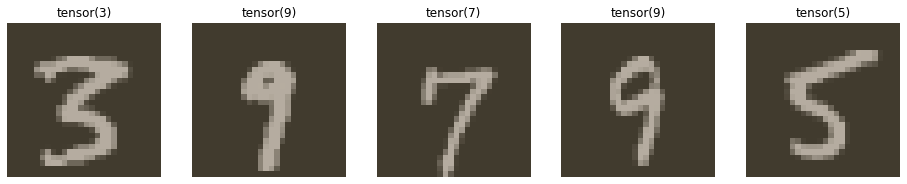

In [32]:
import matplotlib.pyplot as plt

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


# Displaying Images and other info about the test set
images, labels = next(iter(labeled_student_trainloader))
# print(" Image Size",images.size())
rand_idx = np.random.randint(len(images))
# print(labels[rand_idx])

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    # print(" Image Size",images[ii].size())
    ax.set_title(labels[ii])
    imshow(images[ii], ax=ax, normalize=True)

       

In [0]:
# # train model using private and public datasets
# my_model = Net()
# criterion = nn.NLLLoss()
# optimizer = optim.Adam(my_model.parameters(), lr=1e-3)
# train(model=my_model, criterion=criterion, optimizer=optimizer, trainloader=private_loader, validloader=public_loader_labeled)

In [29]:
# Now we train the model
# We use the newly labeled trainloader for training and use the validloader data to evaluate the performance of our model
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)
epochs = 10


student_model = train(model, criterion, optimizer,labeled_student_trainloader,student_valid_loader)

# student_model = train(model, criterion, optimizer,student_trainloader, labeled_student_trainloader)



Epoch: 1/10..  Training Loss: 0.471..  Valid Loss: 0.224..  Valid Accuracy: 0.940  
Epoch: 2/10..  Training Loss: 0.447..  Valid Loss: 0.230..  Valid Accuracy: 0.939  
Epoch: 3/10..  Training Loss: 0.438..  Valid Loss: 0.237..  Valid Accuracy: 0.931  
Epoch: 4/10..  Training Loss: 0.432..  Valid Loss: 0.218..  Valid Accuracy: 0.940  
Epoch: 5/10..  Training Loss: 0.417..  Valid Loss: 0.229..  Valid Accuracy: 0.936  
Epoch: 6/10..  Training Loss: 0.409..  Valid Loss: 0.225..  Valid Accuracy: 0.938  
Epoch: 7/10..  Training Loss: 0.401..  Valid Loss: 0.235..  Valid Accuracy: 0.933  
Epoch: 8/10..  Training Loss: 0.383..  Valid Loss: 0.216..  Valid Accuracy: 0.941  
Epoch: 9/10..  Training Loss: 0.399..  Valid Loss: 0.225..  Valid Accuracy: 0.938  
Epoch: 10/10..  Training Loss: 0.406..  Valid Loss: 0.222..  Valid Accuracy: 0.940  


# TRAIN MNIST NORMALLY